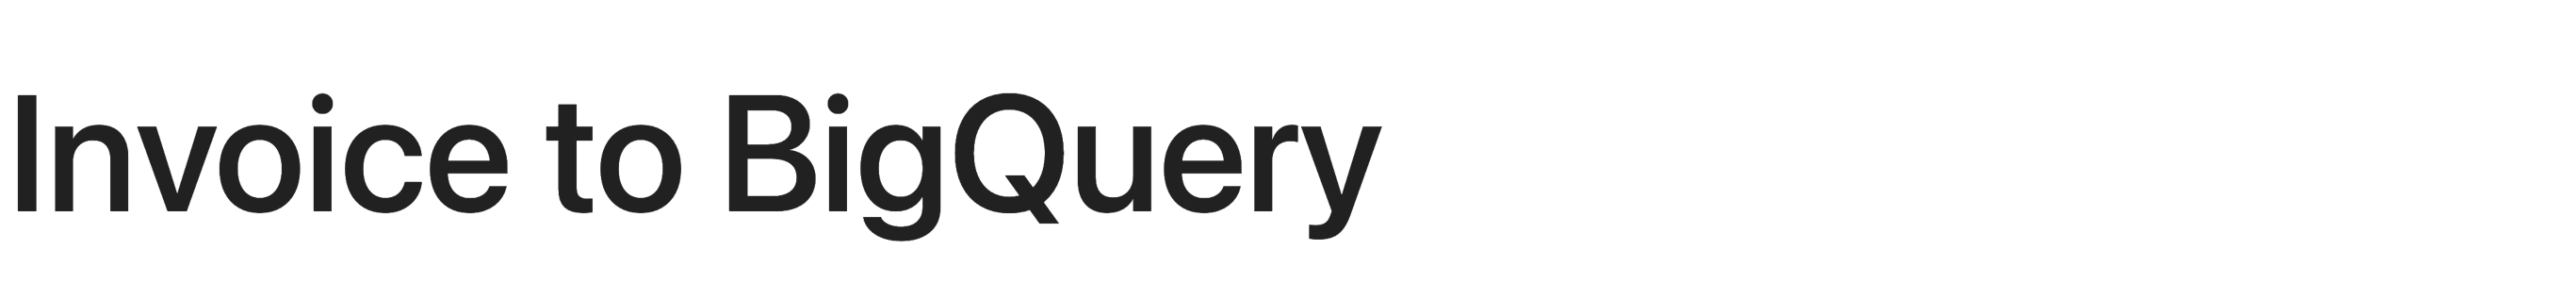

# Document AI : Saving Invoice to BigQuery

### Prerequisites

In [1]:
!cat requirements.txt

Wand==0.6.6
google-cloud-documentai==0.4.0

In [2]:
# !pip install -r requirements.txt

In [3]:
from google.cloud import documentai_v1beta3 as documentai
from google.cloud import bigquery
from IPython.display import Image
import pandas as pd

PROJECT_ID = 'doc-ai-ce'
PROCESSOR_ID = 'e38c82311d145f3b'
LOCATION = 'us'

# Download Invoice

##### <i> More Sample Invoices: https://github.com/GoogleCloudPlatform/documentai-notebooks/tree/master/resources/procurement/invoices

In [4]:
!mkdir -p invoice_samples
!gsutil cp gs://cloud-samples-data/documentai/*invoice* ./invoice_samples/
INVOICE_PDF = './invoice_samples/fake_invoice.pdf'
INVOICE_PNG = './invoice_samples/fake_invoice.png'

Copying gs://cloud-samples-data/documentai/fake_invoice.pdf...
Copying gs://cloud-samples-data/documentai/fake_invoice.png...                  
Copying gs://cloud-samples-data/documentai/invoice.pdf...                       
Omitting prefix "gs://cloud-samples-data/documentai/async_invoices/". (Did you mean to do cp -r?)

Operation completed over 3 objects/245.0 KiB.                                    


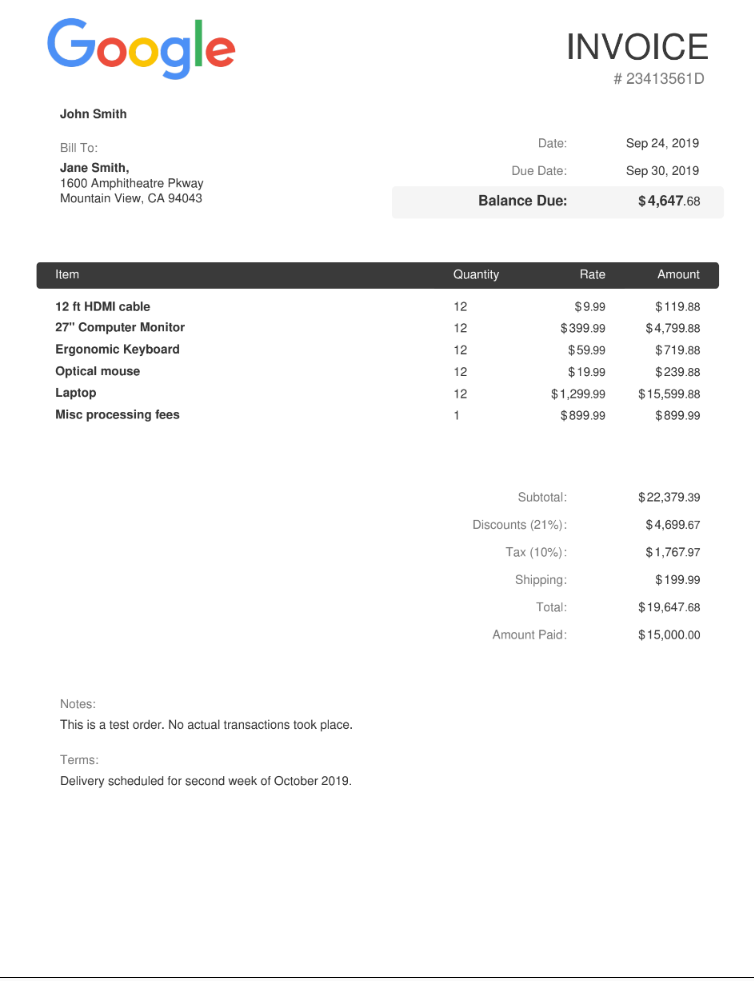

In [5]:
Image(filename=INVOICE_PNG, width=700)

# Process Invoice

### 1. Call Document AI

In [6]:
processor_name = f"projects/{PROJECT_ID}/locations/{LOCATION}/processors/{PROCESSOR_ID}"

with open(INVOICE_PDF, "rb") as image:
    document = {"content": image.read(), "mime_type": "application/pdf"}
    request = {"name": processor_name, "document": document}
    
results = documentai.DocumentProcessorServiceClient().process_document(request=request)

### 2. Gather Entities

In [7]:
results_frame = [[entity.type_, entity.mention_text, round(entity.confidence, 4)] for entity in results.document.entities]
df = pd.DataFrame(results_frame, columns=['type', 'value','confidence'])
df

,type,value,confidence
0,net_amount,"$22,379.39",1.0000
1,due_date,"Sep 30, 2019",0.9958
2,invoice_date,"Sep 24, 2019",0.9681
3,total_amount,"19,647.68",0.9651
4,total_tax_amount,"1,767.97",0.9452
5,invoice_id,23413561D,0.8993
6,currency,$,0.6282
7,freight_amount,$199.99,0.3710
8,receiver_address,"Jane Smith,\n1600 Amphitheatre Pkway\nMountain...",0.2417
9,purchase_order,12,0.0155


### 3. Transform Data

In [8]:
df_t = df.rename(columns={'type':'index'}).drop(columns=['confidence']).T
df_t.columns = df_t.iloc[0]
df_t = df_t.drop(df_t.index[0])
df_t = df_t.reset_index(drop=True) 

df_t = df_t[['invoice_id','purchase_order','due_date'] + [col for col in df_t.columns if '_amount' in col]]

# transform date column
df_t['due_date'] = pd.to_datetime(df_t['due_date'])

# transform amount columns
for num_col in [col for col in df_t.columns if '_amount' in col]:
    df_t[num_col] = pd.to_numeric(df_t[num_col].replace({'\$':'', ',':''}, regex = True))
    
df_t

index,invoice_id,purchase_order,due_date,net_amount,total_amount,total_tax_amount,freight_amount
0,23413561D,12,2019-09-30,22379.39,19647.68,1767.97,199.99


# Save to BigQuery

### 1. Create BigQuery Dataset

<img src='imgs/create_bq_dataset.png' width=1200/>

##### <i>Instructions and Pics Here</i>
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

### 2. Insert Invoice into BigQuery

In [9]:
DATASET = 'dai'
TABLE = 'invoice'

bq = bigquery.Client(project=PROJECT_ID)

In [10]:
bq.delete_table(f'{DATASET}.{TABLE}', not_found_ok=True)

In [11]:
schema=[bigquery.SchemaField("invoice_id", "STRING"),
        bigquery.SchemaField("purchase_order", "STRING"),
        bigquery.SchemaField("due_date", "TIMESTAMP"),
        bigquery.SchemaField("total_tax_amount", "FLOAT"),            
        bigquery.SchemaField("freight_amount", "FLOAT"),
        bigquery.SchemaField("net_amount", "FLOAT"),]

job_config = bigquery.LoadJobConfig(schema=schema)

job = bq.load_table_from_dataframe(df_t, f'{DATASET}.{TABLE}', job_config=job_config)
job.result().state

'DONE'

### 3. Verify Data
##### query back the newly inserted data
https://pantheon.corp.google.com/bigquery?project=doc-ai-ce&p=doc-ai-ce&d=dai&t=invoice&page=table

In [12]:
bq.query(f"""
    SELECT 
        invoice_id,
        purchase_order, 
        cast(due_date AS DATE) due_date,
        net_amount,
        total_amount,
        total_tax_amount,
        freight_amount
    FROM 
        {DATASET}.{TABLE}""").to_dataframe()

,invoice_id,purchase_order,due_date,net_amount,total_amount,total_tax_amount,freight_amount
0,23413561D,12,2019-09-30,22379.39,19647.68,1767.97,199.99


# Another Invoice  

### Now process and save another invoice, all at once.

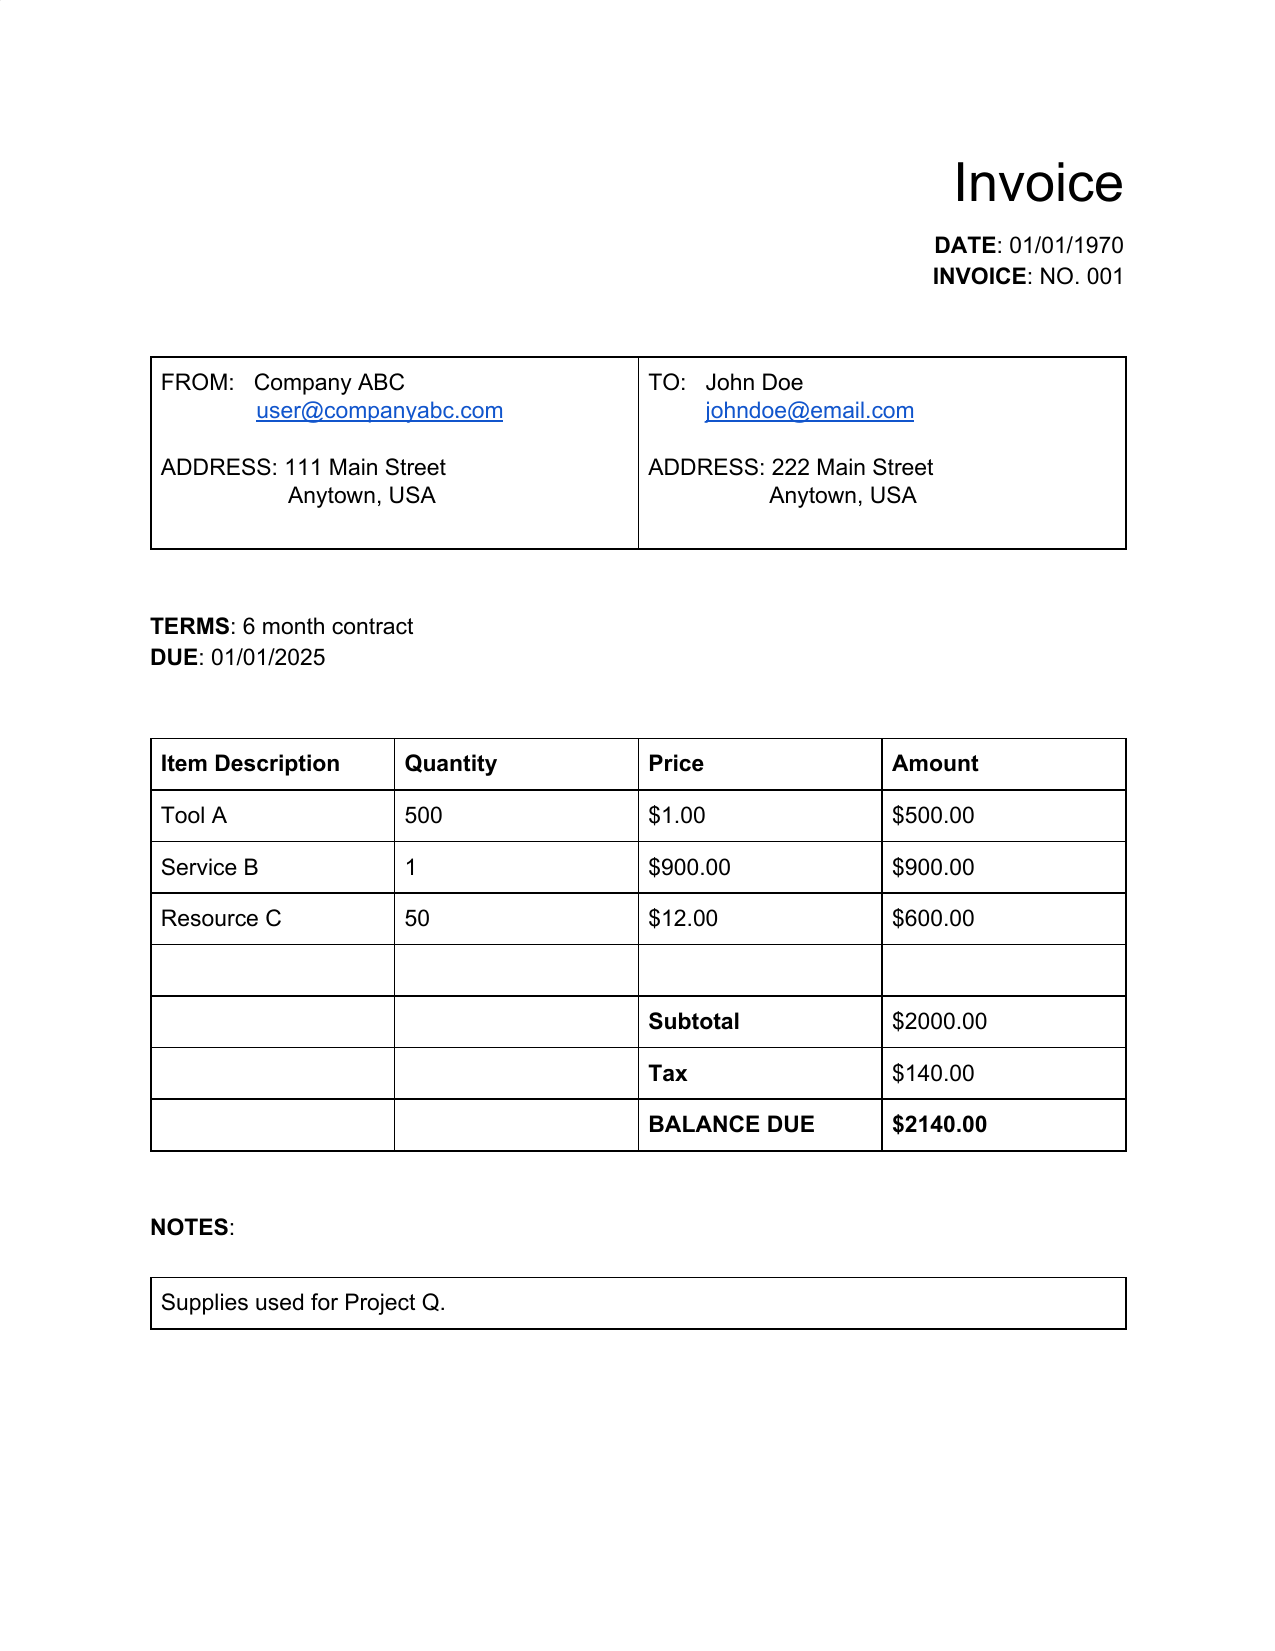

In [13]:
INVOICE_PDF = './invoice_samples/invoice.pdf'
INVOICE_PNG = './invoice_samples/invoice.png'
!pdftoppm {INVOICE_PDF} > {INVOICE_PNG} -png
Image(filename=INVOICE_PNG, width=650)

In [14]:
with open(INVOICE_PDF, "rb") as image:
    document = {"content": image.read(), "mime_type": "application/pdf"}
    request = {"name": processor_name, "document": document}    

results = documentai.DocumentProcessorServiceClient().process_document(request=request)
results_frame = [[entity.type_, entity.mention_text, round(entity.confidence, 4)] for entity in results.document.entities]
df = pd.DataFrame(results_frame, columns=['type', 'value','confidence'])
df

,type,value,confidence
0,net_amount,$2000.00,1.0000
1,invoice_date,01/01/1970,0.9812
2,due_date,01/01/2025,0.9591
3,total_tax_amount,140.00,0.9479
4,invoice_id,001,0.8444
5,payment_terms,6 month contract,0.7743
6,receiver_name,John Doe,0.7147
7,supplier_name,Company ABC,0.7109
8,currency,$,0.7049
9,supplier_address,"111 Main Street\nAnytown, USA",0.4738


In [15]:
df_t = df.rename(columns={'type':'index'}).drop(columns=['confidence']).T
df_t.columns = df_t.iloc[0]
df_t = df_t.drop(df_t.index[0])
df_t = df_t.reset_index(drop=True) 

df_t = df_t[['invoice_id','purchase_order','due_date'] + [col for col in df_t.columns if '_amount' in col]]

# transform date column
df_t['due_date'] = pd.to_datetime(df_t['due_date'])

# transform amount columns
for num_col in [col for col in df_t.columns if '_amount' in col]:
    df_t[num_col] = pd.to_numeric(df_t[num_col].replace({'\$':'', ',':''}, regex = True))
    
df_t

index,invoice_id,purchase_order,due_date,net_amount,total_tax_amount,freight_amount
0,001,500,2025-01-01,2000.0,140.0,900.0


In [17]:
bq.insert_rows_from_dataframe(table=f'{DATASET}.{TABLE}', dataframe=df_t, selected_fields = schema)

[[]]

In [18]:
bq.query(f"""
    SELECT 
        invoice_id,
        purchase_order, 
        cast(due_date AS DATE) due_date,
        net_amount,
        total_amount,
        total_tax_amount,
        freight_amount
    FROM 
        {DATASET}.{TABLE}""").to_dataframe()

,invoice_id,purchase_order,due_date,net_amount,total_amount,total_tax_amount,freight_amount
0,23413561D,12,2019-09-30,22379.39,19647.68,1767.97,199.99
1,001,500,2025-01-01,2000.00,NaN,140.00,900.00


# Check Directly in BigQuery UI

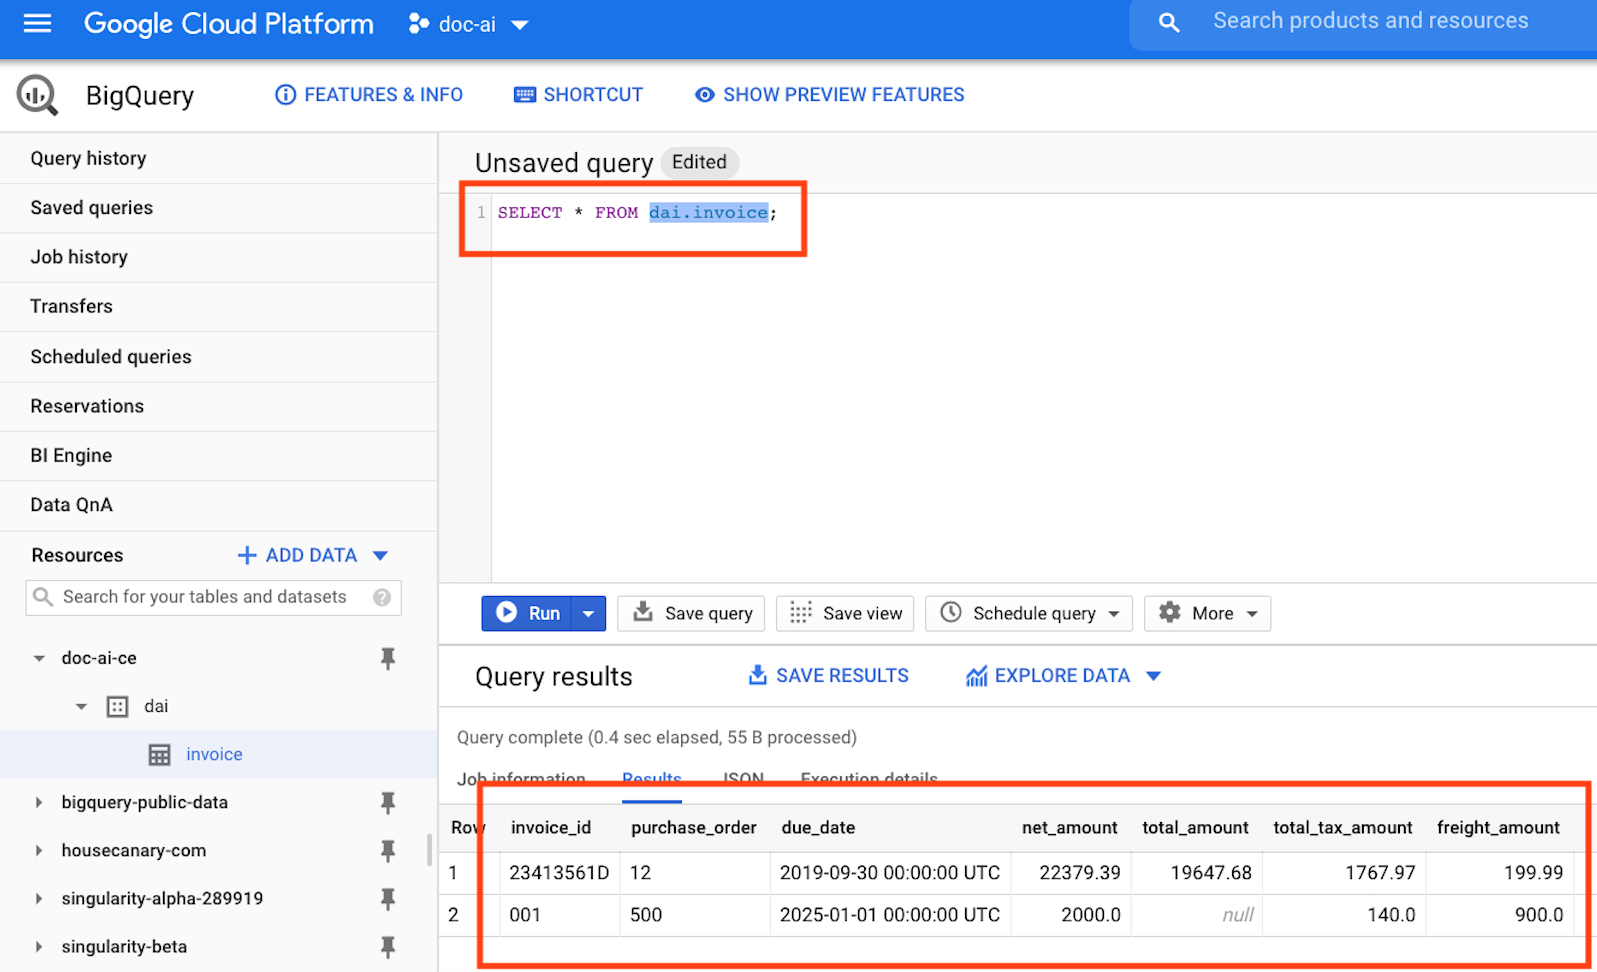